In [1]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import nltk, re, string
from string import punctuation
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, recall_score, roc_auc_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")

import spacy

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abhishek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/abhishek/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/abhishek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/abhishek/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Load the dataset
df = pd.read_csv("train.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


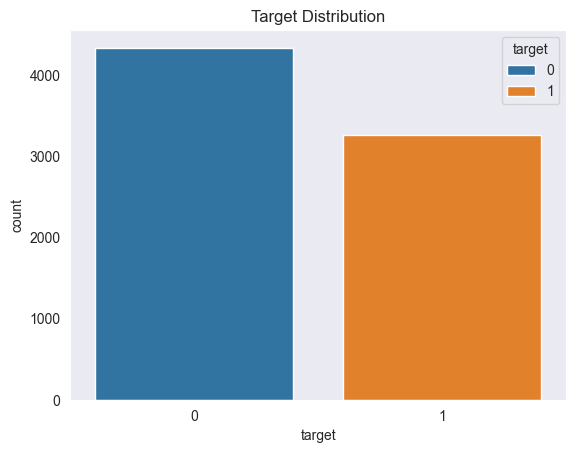

In [3]:
# Plot the target distribution
sns.set_style("dark")
sns.countplot(x='target', data=df, hue='target')
plt.title("Target Distribution")
plt.show()

In [4]:
# Creating a new column for storing the length of the reviews
df["length"] = df["text"].apply(len)
df.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


<Axes: ylabel='Frequency'>

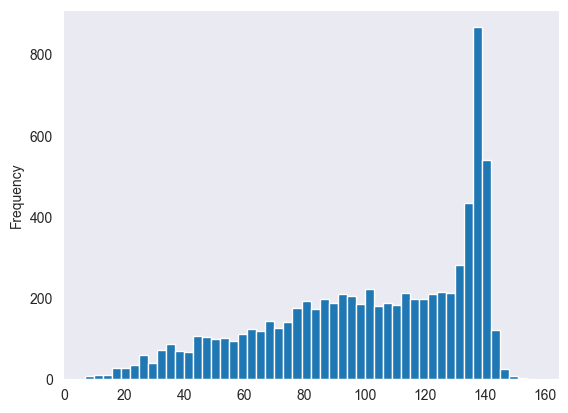

In [5]:
df["length"].plot.hist(bins=50)

In [6]:
df.length.describe()

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

In [7]:
# Checking the longest review
df[df['length'] == 157]['text'].iloc[0]

"when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????"

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

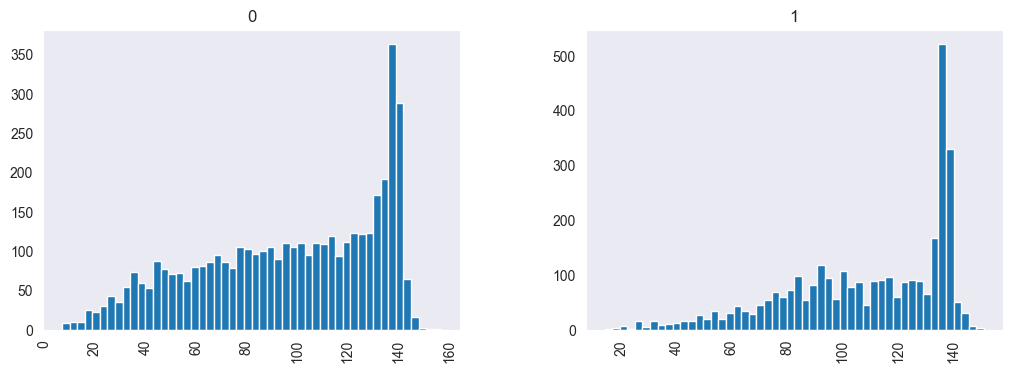

In [8]:
df.hist(column='length', by='target', bins=50,figsize=(12,4))

In [9]:
# Importing the set of English stopwords from the NLTK library
stop = set(stopwords.words("english"))

# Adding punctuation symbols to the stopwords list for further filtering
punctuation = list(string.punctuation)
stop.update(punctuation)

# Defining a function to remove stopwords and punctuation from the input text
# This helps in cleaning the text by keeping only relevant words
def remove_stopwords(text):
    final_text = []
    # Splitting the text into individual words
    for i in text.split():
        # Checking if the word is not in the stopwords set and appending it to the final list
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    # Returning the cleaned text as a single string
    return " ".join(final_text)

# Separating the dataset into two subsets based on the target column
# df_1 contains rows with target=1 (Disaster-related tweets)
# df_0 contains rows with target=0 (Non-disaster tweets)
df_1 = df[df["target"] == 1]
df_0 = df[df["target"] == 0]

# Applying the remove_stopwords function to the 'text' column in both subsets
# This cleans the text by removing unnecessary stopwords and punctuation
df_1["text"] = df_1["text"].apply(remove_stopwords)
df_0["text"] = df_0["text"].apply(remove_stopwords)

/var/folders/hy/b8mrcp_x1sxbt1d3f8hfqcmm0000gn/T/ipykernel_56958/1598006296.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1["text"] = df_1["text"].apply(remove_stopwords)
/var/folders/hy/b8mrcp_x1sxbt1d3f8hfqcmm0000gn/T/ipykernel_56958/1598006296.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0["text"] = df_0["text"].apply(remove_stopwords)


### Plotting wordcloud of Disaster Tweets

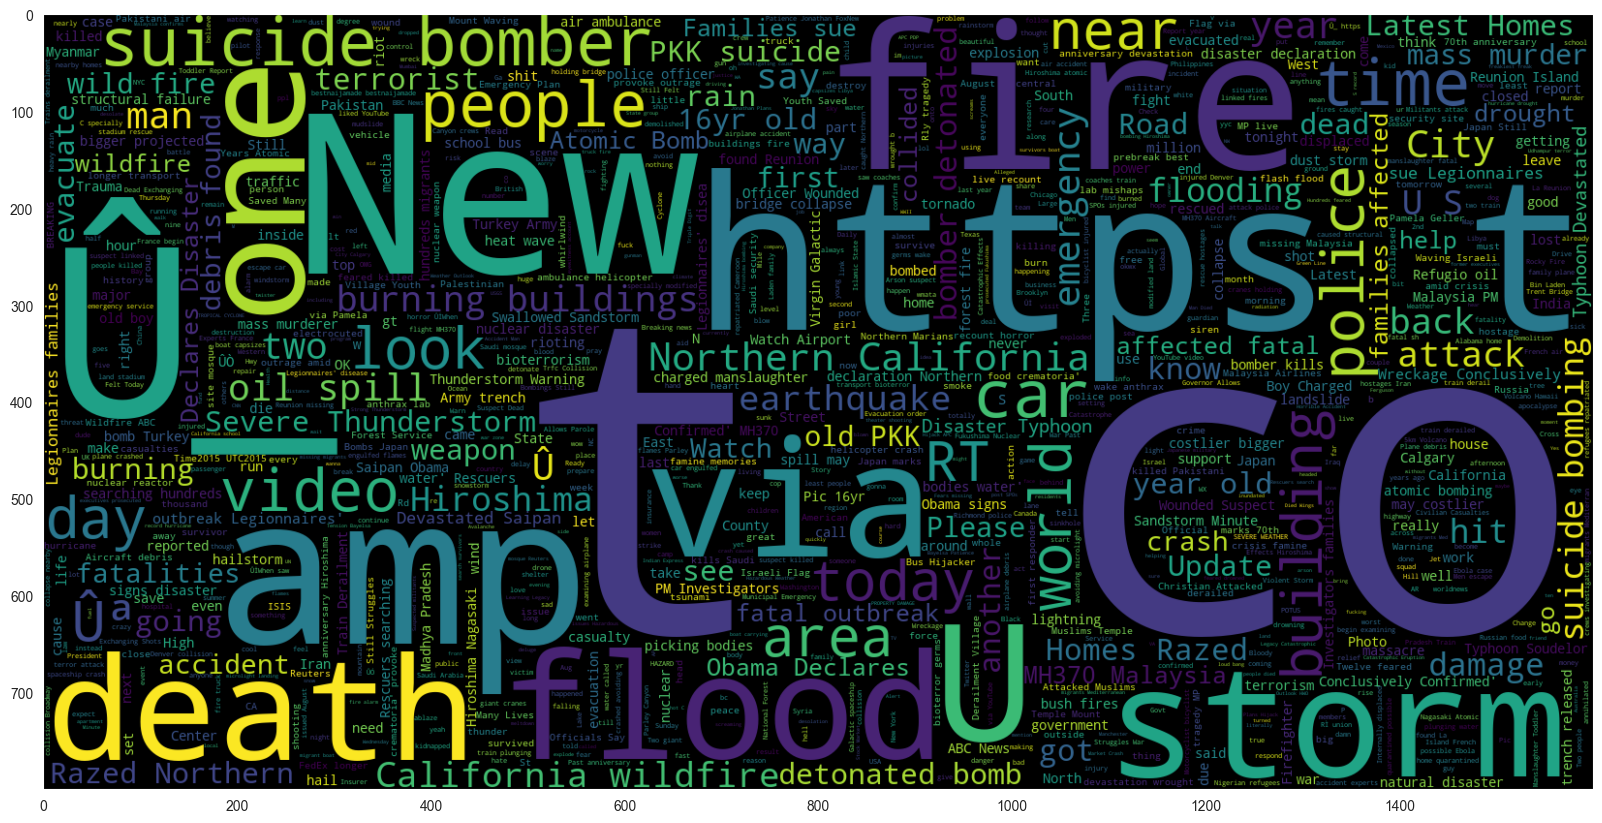

In [10]:
from wordcloud import WordCloud
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, width=1600, height=800).generate(" ".join(df_1.text))
plt.imshow(wc, interpolation="bilinear")

### Plotting wordcloud of Normal Tweets

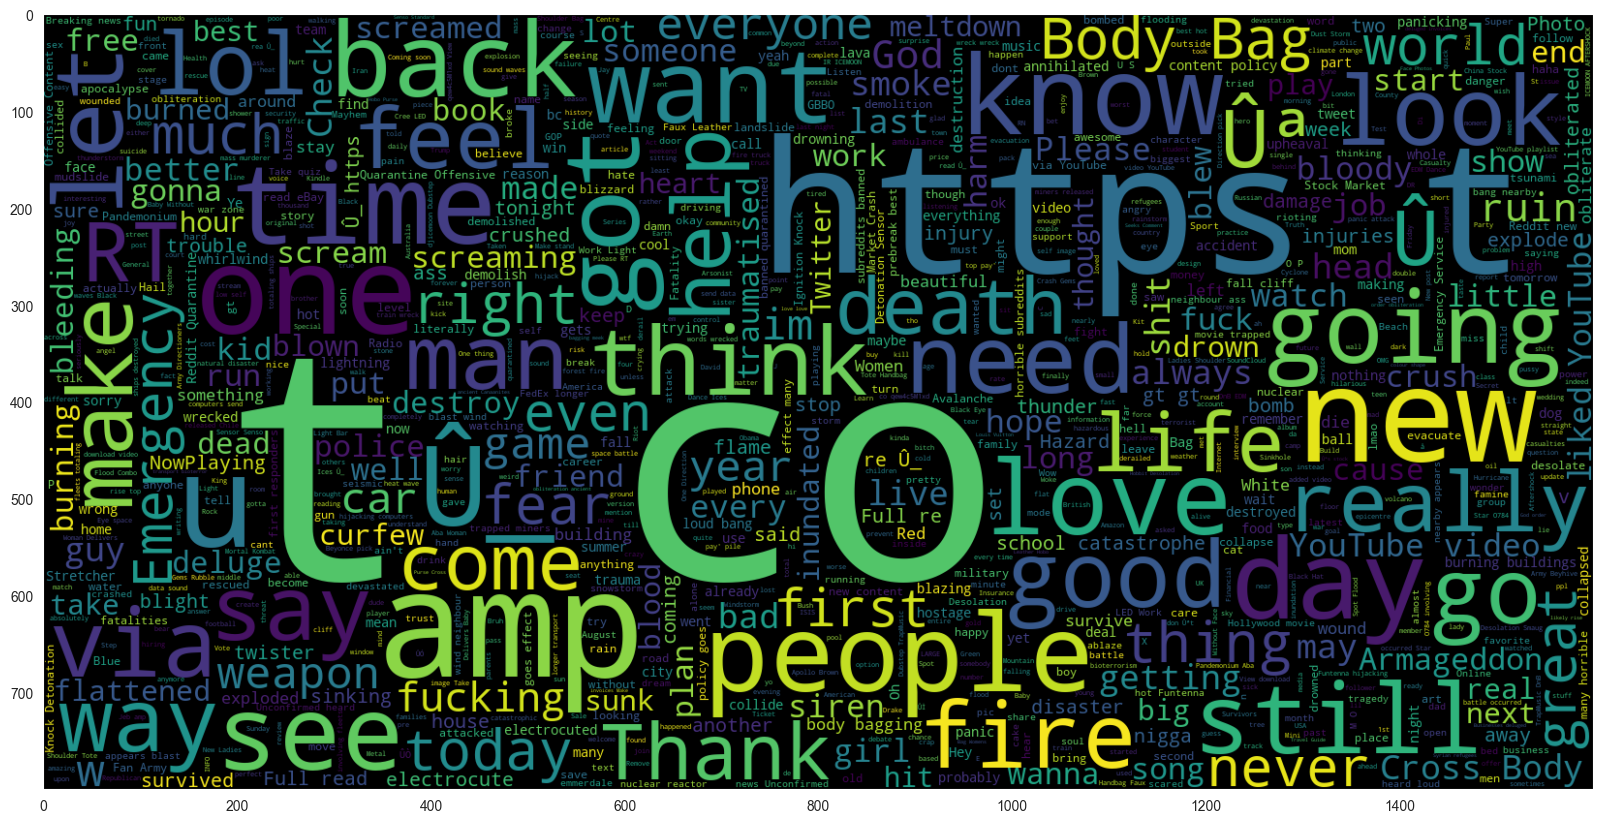

In [11]:
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, width=1600, height=800).generate(" ".join(df_0.text))
plt.imshow(wc, interpolation="bilinear")

### Data Cleaning and Preparation

In [12]:
# Load spaCy's pre trained model
nlp = spacy.load("en_core_web_sm")

# Clean tweet function using spaCy
def cleanTweet(txt):
    # Lowercase the text
    txt = txt.lower()

    # Tokenization and lemmitization using spaCy
    doc = nlp(txt)

    # Remove stopwords and lemmitize the words
    words = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]

    text = " ".join(words)

    # Remove non-alphabetic characters (though spaCy will ignore these during lemmatization)
    txt = re.sub("[^a-z]", " ", text)

    return txt

### Applying Clean Tweet Function on Tweets Text

In [13]:
df["cleaned_tweets"] = df["text"].apply(cleanTweet)
df.head()

,id,keyword,location,text,target,length,cleaned_tweets
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,deed reason earthquake allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,get send photo ruby alaska smoke wildfire pour...


### Creating Feature & Target Variables

In [14]:
y = df.target
X = df.cleaned_tweets

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

### TF-IDF Vectorizer - Bi-Gram

In [16]:
# Using TfidfVectorizer Bi-Gram to convert text data into numbers

tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_df=0.8, ngram_range=(1,2))
tfidf_train_2 = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer.transform(X_test)

### Multinomial Naive Bayes

In [17]:
# Model Fitting
mnb_tf = MultinomialNB()
mnb_tf.fit(tfidf_train_2, y_train)

MultinomialNB()

### 10-Fold Cross Validation

In [18]:
from sklearn import model_selection

kfold = model_selection.KFold(n_splits=10)
scoring = 'accuracy'

acc_mnb2 = cross_val_score(estimator=mnb_tf, X=tfidf_train_2, y = y_train, cv=kfold, scoring=scoring)
acc_mnb2.mean()

0.7950738916256158

### Model Prediction Test set

,Model,Accuracy,Precision,Recall,Specificity,F1 Score
0,Multinomial Naive Bayes - TFIDF-BiGram,0.814839,0.867589,0.671254,0.9229,0.756897


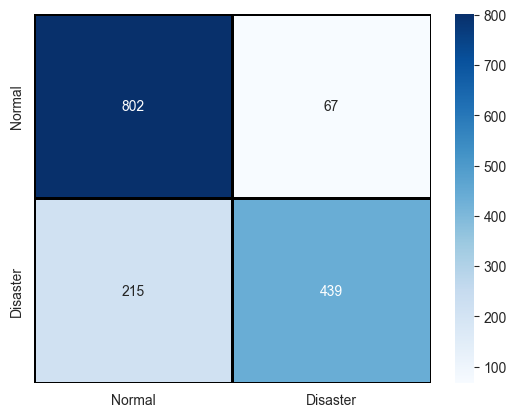

In [19]:
pred_mnb2 = mnb_tf.predict(tfidf_test_2)
CM = confusion_matrix(y_test, pred_mnb2)
sns.heatmap(CM, cmap="Blues", linecolor="black", linewidths=1, annot=True, fmt="", xticklabels=["Normal", "Disaster"], yticklabels=["Normal", "Disaster"])

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
specificity = TN/(TN+FP)

acc = accuracy_score(y_test, pred_mnb2)

prec = precision_score(y_test, pred_mnb2)
rec = recall_score(y_test, pred_mnb2)
f1 = f1_score(y_test, pred_mnb2)

model_results = pd.DataFrame([["Multinomial Naive Bayes - TFIDF-BiGram", acc, prec, rec, specificity, f1]], columns=["Model", "Accuracy", "Precision", "Recall", "Specificity", "F1 Score"])

model_results

### Passive Aggressive Classifier

In [20]:
pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_2, y_train)

PassiveAggressiveClassifier()

### 10-Fold Cross Validation

In [21]:
kfold = model_selection.KFold(n_splits=10)
scoring = 'accuracy'

acc_pass2 = cross_val_score(estimator=pass_tf, X= tfidf_train_2, y = y_train, cv=kfold, scoring=scoring)

acc_pass2.mean()

0.7821018062397372

### Model Prediction

/var/folders/hy/b8mrcp_x1sxbt1d3f8hfqcmm0000gn/T/ipykernel_56958/1513662399.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = model_results.append(results, ignore_index=True)


,Model,Accuracy,Precision,Recall,Specificity,F1 Score
0,Multinomial Naive Bayes - TFIDF-BiGram,0.814839,0.867589,0.671254,0.9229,0.756897
1,Passive Aggressive Classifier - TFIDF-BiGram,0.785292,0.770248,0.712538,0.9229,0.740270


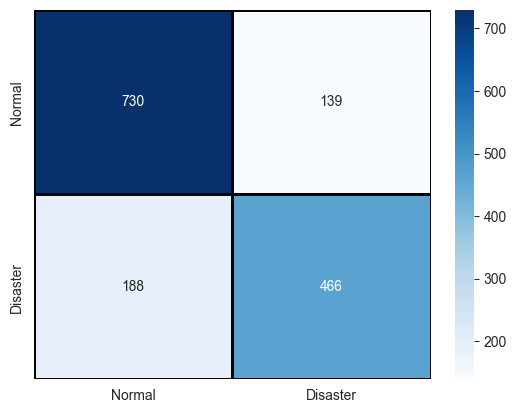

In [22]:
pred_pass2 = pass_tf.predict(tfidf_test_2)
CM = confusion_matrix(y_test, pred_pass2)
sns.heatmap(CM, cmap="Blues", linecolor="black", linewidths=1, annot=True, fmt="", xticklabels=["Normal", "Disaster"], yticklabels=["Normal", "Disaster"])

acc = accuracy_score(y_test, pred_pass2)
prec = precision_score(y_test, pred_pass2)
rec = recall_score(y_test, pred_pass2)
f1 = f1_score(y_test, pred_pass2)

results = pd.DataFrame([["Passive Aggressive Classifier - TFIDF-BiGram", acc, prec, rec, specificity, f1]], columns=["Model", "Accuracy", "Precision", "Recall", "Specificity", "F1 Score"])
results = model_results.append(results, ignore_index=True)
results

### TF-IDF Vectorizer - Tri Gram

In [23]:
# Using TfidfVectorizer Tri-Gram to convert text data into numbers

tfidf_vectorizer_3 = TfidfVectorizer(stop_words="english", max_df=0.8, ngram_range=(1,3))
tfidf_train_3 = tfidf_vectorizer_3.fit_transform(X_train)
tfidf_test_3 = tfidf_vectorizer_3.transform(X_test)

### Multinomial Naive Bayes - Tri Gram

In [24]:
mnb_tf3 = MultinomialNB()
mnb_tf3.fit(tfidf_train_3, y_train)

MultinomialNB()

### 10-fold cross validation


In [25]:
kfold = model_selection.KFold(n_splits=10)
scoring = 'accuracy'

acc_mnb3 = cross_val_score(estimator=mnb_tf3, X=tfidf_train_3, y=y_train, cv=kfold, scoring=scoring)
acc_mnb3.mean()

0.7914614121510674

### Model Prediction

/var/folders/hy/b8mrcp_x1sxbt1d3f8hfqcmm0000gn/T/ipykernel_56958/1613826183.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(mod_results, ignore_index=True)


,Model,Accuracy,Precision,Recall,Specificity,F1 Score
0,Multinomial Naive Bayes - TFIDF-BiGram,0.814839,0.867589,0.671254,0.922900,0.756897
1,Passive Aggressive Classifier - TFIDF-BiGram,0.785292,0.770248,0.712538,0.922900,0.740270
2,Multinomial Naive Bayes - TFIDF-TriGram,0.812869,0.880412,0.652905,0.933257,0.749781


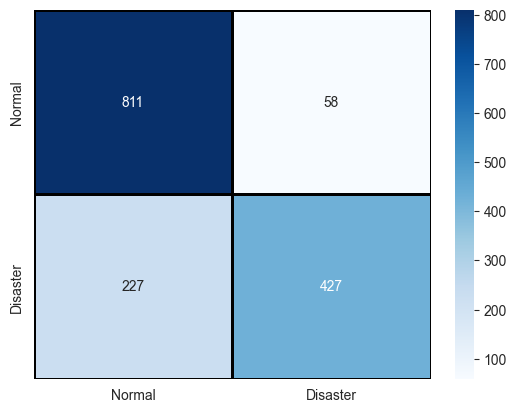

In [26]:
pred_mnb3 = mnb_tf3.predict(tfidf_test_3)
CM = confusion_matrix(y_test, pred_mnb3)
sns.heatmap(CM, cmap="Blues", linecolor="black", linewidths=1, annot=True, fmt="", xticklabels=["Normal", "Disaster"], yticklabels=["Normal", "Disaster"])

TN = CM[0][0]
FP = CM[0][1]
Specificity = TN / (TN + FP)

acc = accuracy_score(y_test, pred_mnb3)
prec = precision_score(y_test, pred_mnb3)
rec = recall_score(y_test, pred_mnb3)
f1 = f1_score(y_test, pred_mnb3)

mod_results = pd.DataFrame([["Multinomial Naive Bayes - TFIDF-TriGram", acc, prec, rec, Specificity, f1]], columns=["Model", "Accuracy", "Precision", "Recall", "Specificity", "F1 Score"])
results = results.append(mod_results, ignore_index=True)
results

### Passive Aggressive Classifier - Tri Gram

In [27]:
pass_tf3 = PassiveAggressiveClassifier()
pass_tf3.fit(tfidf_train_3, y_train)

# Cross Validation
kfold = model_selection.KFold(n_splits=10)
scoring = "accuracy"

acc_pass3 = cross_val_score(estimator=pass_tf3, X = tfidf_train_3, y = y_train, cv=kfold, scoring=scoring)
acc_pass3.mean()

0.7812807881773398

### Model Prediction

/var/folders/hy/b8mrcp_x1sxbt1d3f8hfqcmm0000gn/T/ipykernel_56958/2503288932.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(mod1_results, ignore_index=True)


,Model,Accuracy,Precision,Recall,Specificity,F1 Score
0,Multinomial Naive Bayes - TFIDF-BiGram,0.814839,0.867589,0.671254,0.922900,0.756897
1,Passive Aggressive Classifier - TFIDF-BiGram,0.785292,0.770248,0.712538,0.922900,0.740270
2,Multinomial Naive Bayes - TFIDF-TriGram,0.812869,0.880412,0.652905,0.933257,0.749781
3,Passive Aggressive Classifier - TFIDF-TriGram,0.776756,0.741538,0.737003,0.933257,0.739264


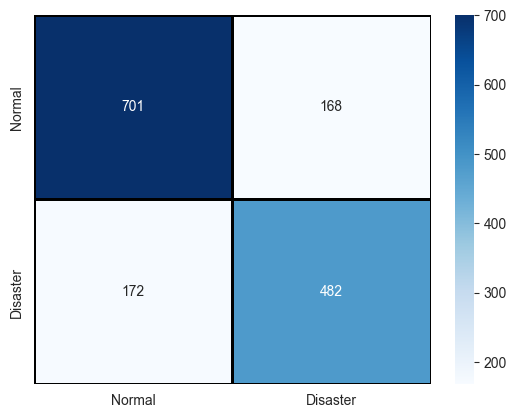

In [28]:
pred_pass3 = pass_tf3.predict(tfidf_test_3)
CM = confusion_matrix(y_test, pred_pass3)
sns.heatmap(CM, cmap="Blues", linecolor="black", linewidths=1, annot=True, fmt="", xticklabels=["Normal", "Disaster"], yticklabels=["Normal", "Disaster"])

acc = accuracy_score(y_test, pred_pass3)
prec = precision_score(y_test, pred_pass3)
rec = recall_score(y_test, pred_pass3)
f1 = f1_score(y_test, pred_pass3)

mod1_results = pd.DataFrame([["Passive Aggressive Classifier - TFIDF-TriGram", acc, prec, rec, Specificity, f1]], columns=["Model", "Accuracy", "Precision", "Recall", "Specificity", "F1 Score"])
results = results.append(mod1_results, ignore_index=True)
results

### Most Informative Features

In [29]:
# Function to display the most informative features for binary classification
# This function helps in identifying which features (words) are most influential
# in determining the target class for a binary classification problem

def most_informative_feature_for_binary_classification(vectorizer, classifier, n=100):
    # Getting the class labels from the classifier (e.g., 0 and 1 for binary classification)
    class_labels = classifier.classes_
    
    # Extracting feature names from the vectorizer (e.g., TF-IDF or CountVectorizer)
    feature_names = vectorizer.get_feature_names_out()
    
    # Sorting the coefficients for class 0 (or negative class) to identify top n features
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    
    # Sorting the coefficients for class 1 (or positive class) to identify top n features
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    # Printing the most informative features for class 0
    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)
    
    print()  # Adding a blank line for readability

    # Printing the most informative features for class 1
    for coef, feat in reversed(topn_class2):
        print(class_labels[1], coef, feat)

In [30]:
# Most informative features for Passive Aggressive Classifier
most_informative_feature_for_binary_classification(tfidf_vectorizer_3, pass_tf3, n=10)
# Returns feature importance coefficients: Positive coef = disaster, Negative coef = normal tweets

0 -3.17206946332202 rt short
0 -3.17206946332202 rt short reading
0 -3.1069130435323324 rt gunshot
0 -3.1069130435323324 rt gunshot wound
0 -2.3019422097339866 age
0 -2.0807115383001897 image quiz mg
0 -2.0807115383001897 mg
0 -2.0807115383001897 quiz mg
0 -2.0531383661995735 let
0 -2.0428187397409747 suicide bomb

1 3.8807752967108753 hiroshima
1 3.6087808164489132 wildfire
1 3.518062877021361 california
1 3.476329164371261 rt tanzania elephant
1 3.476329164371261 rt tanzania
1 3.4614239410127823 building
1 3.1963097340248314 bombing
1 3.1288820082900073 forest
1 2.812572368968037 wild
1 2.776755416572019 flood


In [39]:
# Most informative features for Multinomial Naive Bayes
most_informative_feature_for_binary_classification(tfidf_vectorizer, mnb_tf, n=10) 
# Returns log probabilities: Less negative = stronger association with disasters, More negative = normal tweets

0 -10.823942592589647 aa mgm
0 -10.823942592589647 aaaa
0 -10.823942592589647 aaaa ok
0 -10.823942592589647 aannnnd
0 -10.823942592589647 aannnnd reddit
0 -10.823942592589647 aar
0 -10.823942592589647 aar decide
0 -10.823942592589647 ab
0 -10.823942592589647 ab resin
0 -10.823942592589647 abandon cocker

1 -7.784739166547718 kill
1 -7.882851781008938 california
1 -7.960565859904377 news
1 -7.966589135764428 family
1 -8.019510862086406 crash
1 -8.021735481406889 suicide
1 -8.060579067614249 disaster
1 -8.064399052127683 building
1 -8.076995514768711 bomb
1 -8.077880349642292 home


/Users/abhishek/tensorflow-test/env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


## Same Process on Test Data

In [32]:
# 1. Load the Test Data
test_df = pd.read_csv("test.csv")
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [33]:
# 2. Preprocess the Test Data
test_df["cleaned_tweets"] = test_df["text"].apply(cleanTweet)

In [34]:
# 3. Transform the Test Data with the Pre-fitted TF-IDF Vectorizer (tfidf_vectorizer_3)
tfidf_test = tfidf_vectorizer_3.transform(test_df["cleaned_tweets"])

In [35]:
# 4. Model Prediction
predictions = pass_tf3.predict(tfidf_test)

In [36]:
# Check the length of predictions
print("Length of predictions:", len(predictions))  # Should be 3263

Length of predictions: 3263


In [37]:
# 5. Prepare the Submission File
submission_df = pd.DataFrame({
    "id": test_df["id"],  # Or use the appropriate column name for the tweet IDs in your test dataset
    "target": predictions  # The predicted labels (Normal or Disaster)
})

In [38]:
# Save the results to a CSV file for submission
submission_df.to_csv("submission.csv", index=False)